In [1]:
!pip install pandas

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ----------------------- ---------------- 6.6/11.0 MB 38.1 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 37.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   --------------------------------- ------ 10.7/12.8 MB 52.5 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 48.5 MB/s eta 0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
!pip install flask
!pip install flask-cors


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


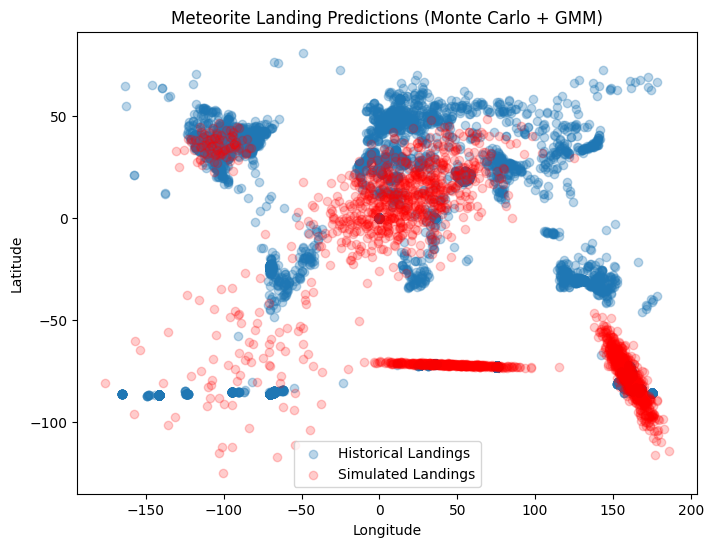

In [94]:
# Simulation graph
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


df = pd.read_csv("Meteorite_Landings.csv")

df = df.dropna(subset=["reclat", "reclong", "mass (g)", "year"])  
coords = df[["reclat", "reclong"]].values
features = df[["mass (g)", "year"]].values

gmm = GaussianMixture(n_components=5, covariance_type="full", random_state=42)
gmm.fit(coords)

df["cluster"] = gmm.predict(coords)


def simulate_landings(n_samples=1000, input_mass=5000, input_year=2025):
    
    mass_noise = np.random.normal(input_mass, input_mass*0.2, n_samples)
    year_noise = np.random.normal(input_year, 1, n_samples)  
    
    cluster_choices = np.random.choice(
        np.arange(gmm.n_components), 
        size=n_samples, 
        p=gmm.weights_
    )
    

    simulated_coords = []
    for cluster in cluster_choices:
        mean = gmm.means_[cluster]
        cov = gmm.covariances_[cluster]
        sample = np.random.multivariate_normal(mean, cov)
        simulated_coords.append(sample)
    
    return np.array(simulated_coords), mass_noise, year_noise

# Example: simulate landings for a new meteor
sim_coords, sim_mass, sim_year = simulate_landings(
    n_samples=2000, 
    input_mass=10000, 
    input_year=2030
)

# === Step 3: Visualization of predicted landing points ===
plt.figure(figsize=(8,6))
plt.scatter(df["reclong"], df["reclat"], alpha=0.3, label="Historical Landings")
plt.scatter(sim_coords[:,1], sim_coords[:,0], alpha=0.2, color="red", label="Simulated Landings")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Meteorite Landing Predictions (Monte Carlo + GMM)")
plt.show()


In [87]:
# Data preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Drop rows where coords are missing or zero
df = df[(df["reclat"] != 0) & (df["reclong"] != 0)]
df = df.dropna(subset=["reclat", "reclong", "mass (g)", "year", "recclass", "velocity_km_s"])
le = LabelEncoder()
df["recclass_encoded"] = le.fit_transform(df["recclass"])
# Add engineered features
df_enhanced['mass_log'] = np.log1p(df_enhanced['mass (g)'])
df_enhanced['velocity_squared'] = df_enhanced['velocity_km_s'] ** 2
df_enhanced['momentum'] = df_enhanced['mass (g)'] * df_enhanced['velocity_km_s']
df_enhanced['kinetic_energy'] = 0.5 * df_enhanced['mass (g)'] * (df_enhanced['velocity_km_s'] ** 2)
df_enhanced['year_modern'] = (df_enhanced['year'] >= 2000).astype(int)
df_enhanced['mass_velocity_interaction'] = df_enhanced['mass_log'] * df_enhanced['velocity_km_s']

# Features
X = df_enhanced[[
    'mass (g)', 'year', 'recclass_encoded', 'velocity_km_s',
    'mass_log', 'velocity_squared', 'momentum', 'kinetic_energy',
    'year_modern', 'mass_velocity_interaction'
]]
y = df_enhanced[['reclat', 'reclong']]

print(f"✓ Using {X.shape[1]} features")
print(f"✓ Training on {len(X)} meteorites")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


0        284
1        164
2         69
3          0
4        289
        ... 
45711     84
45712    370
45713    149
45714    289
45715    265
Name: recclass_encoded, Length: 31705, dtype: int64


In [ ]:
# Velocity calculations
import numpy as np
import pandas as pd

def estimate_meteorite_velocity(mass, recclass, year):
    """
    Estimate meteorite velocity based on mass, class, and year.
    
    Args:
        mass: Mass in grams
        recclass: Meteorite classification (e.g., 'H5', 'L6', 'Iron')
        year: Year of fall/find
    
    Returns:
        velocity: Estimated velocity in km/s
    """
    
    # Base velocities for different meteorite types (km/s)
    # Based on typical cosmic velocities
    velocity_by_class = {
        # Ordinary Chondrites (most common)
        'H': 15.0,   # High iron
        'L': 16.0,   # Low iron
        'LL': 17.0,  # Low iron, low metal
        
        # Carbonaceous Chondrites (slower, more fragile)
        'C': 12.0,
        'CI': 11.0,
        'CM': 12.5,
        'CO': 13.0,
        'CV': 13.5,
        'CK': 14.0,
        'CR': 12.0,
        
        # Enstatite Chondrites
        'E': 14.0,
        'EH': 14.5,
        'EL': 14.0,
        
        # Achondrites (faster, from differentiated bodies)
        'Eucrite': 18.0,
        'Howardite': 18.5,
        'Diogenite': 18.0,
        'Aubrite': 19.0,
        'Ureilite': 17.5,
        
        # Iron meteorites (dense, high velocity survivors)
        'Iron': 20.0,
        'Mesosiderite': 19.0,
        'Pallasite': 19.5,
        
        # Default for unknown
        'Unknown': 15.0
    }
    
    # Extract base class (first letter(s) before numbers)
    base_class = ''.join([c for c in str(recclass) if not c.isdigit()]).strip()
    
    # Get base velocity
    base_velocity = velocity_by_class.get(base_class, velocity_by_class['Unknown'])
    
    # Mass effect: Larger masses survive higher velocities
    # Smaller meteorites decelerate more in atmosphere
    # Using logarithmic scale
    mass_kg = mass / 1000.0
    if mass_kg < 0.001:  # Very small (<1g)
        mass_factor = 0.3  # Heavy deceleration
    elif mass_kg < 0.1:  # Small (1-100g)
        mass_factor = 0.5
    elif mass_kg < 1.0:  # Medium (100g-1kg)
        mass_factor = 0.7
    elif mass_kg < 10.0:  # Large (1-10kg)
        mass_factor = 0.85
    elif mass_kg < 100.0:  # Very large (10-100kg)
        mass_factor = 0.95
    else:  # Massive (>100kg)
        mass_factor = 1.0
    
    # Year effect: Detection methods improved over time
    # Modern detections might catch slower meteorites that would have been missed
    if year < 1900:
        year_factor = 1.1  # Only fastest/brightest detected
    elif year < 1950:
        year_factor = 1.05
    elif year < 2000:
        year_factor = 1.0
    else:
        year_factor = 0.95  # Better detection of slower meteors
    
    # Calculate final velocity
    velocity = base_velocity * mass_factor * year_factor
    
    # Add some realistic variance (±10%)
    velocity_with_noise = velocity * np.random.uniform(0.9, 1.1)
    
    return velocity_with_noise


# Example usage for your dataset
def add_velocity_to_dataset(df):
    """
    Add velocity estimates to your meteorite dataset
    """
    df = df.copy()
    df['velocity_km_s'] = df.apply(
        lambda row: estimate_meteorite_velocity(
            row['mass (g)'], 
            row['recclass'], 
            row['year']
        ), 
        axis=1
    )
    return df


# Test examples
print("=== Velocity Estimates ===\n")

test_cases = [
    (10000, "H5", 2025, "Large ordinary chondrite, modern"),
    (100, "H5", 2025, "Small ordinary chondrite, modern"),
    (50000, "Iron", 1900, "Large iron meteorite, historical"),
    (500, "CI", 2020, "Small carbonaceous chondrite, modern"),
    (1000, "Eucrite", 2015, "Medium achondrite, modern"),
]

for mass, recclass, year, description in test_cases:
    velocities = [estimate_meteorite_velocity(mass, recclass, year) for _ in range(100)]
    mean_vel = np.mean(velocities)
    std_vel = np.std(velocities)
    print(f"{description}:")
    print(f"  Mass: {mass}g, Class: {recclass}, Year: {year}")
    print(f"  Estimated velocity: {mean_vel:.2f} ± {std_vel:.2f} km/s")
    print()


# Integration with your model
print("\n=== Integration Example ===\n")
print("To add velocity to your prediction pipeline:\n")

example_code = """
# 1. Add velocity to your training data
df['velocity_km_s'] = df.apply(
    lambda row: estimate_meteorite_velocity(
        row['mass (g)'], 
        row['recclass'], 
        row['year']
    ), 
    axis=1
)

# 2. Add velocity as a feature
X = df[['mass (g)', 'year', 'recclass_encoded', 'velocity_km_s']]
y = df[['reclat', 'reclong']]

# 3. Scale and train as before
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. When predicting, calculate velocity for input
sample_velocity = estimate_meteorite_velocity(
    mass=10000, 
    recclass="H5", 
    year=2025
)

sample = pd.DataFrame([[10000, 2025, encoded_class, sample_velocity]],
                      columns=["mass (g)", "year", "recclass_encoded", "velocity_km_s"])
"""

print(example_code)

=== Velocity Estimates ===

Large ordinary chondrite, modern:
  Mass: 10000g, Class: H5, Year: 2025
  Estimated velocity: 13.56 ± 0.79 km/s

Small ordinary chondrite, modern:
  Mass: 100g, Class: H5, Year: 2025
  Estimated velocity: 9.96 ± 0.55 km/s

Large iron meteorite, historical:
  Mass: 50000g, Class: Iron, Year: 1900
  Estimated velocity: 19.67 ± 1.13 km/s

Small carbonaceous chondrite, modern:
  Mass: 500g, Class: CI, Year: 2020
  Estimated velocity: 7.34 ± 0.43 km/s

Medium achondrite, modern:
  Mass: 1000g, Class: Eucrite, Year: 2015
  Estimated velocity: 14.58 ± 0.84 km/s


=== Integration Example ===

To add velocity to your prediction pipeline:


# 1. Add velocity to your training data
df['velocity_km_s'] = df.apply(
    lambda row: estimate_meteorite_velocity(
        row['mass (g)'], 
        row['recclass'], 
        row['year']
    ), 
    axis=1
)

# 2. Add velocity as a feature
X = df[['mass (g)', 'year', 'recclass_encoded', 'velocity_km_s']]
y = df[['reclat', 'reclon

Original dataset shape: (45716, 10)

First few rows before adding velocity:
       name   id nametype     recclass  mass (g)  fall    year    reclat  \
0    Aachen    1    Valid           L5      21.0  Fell  1880.0  50.77500   
1    Aarhus    2    Valid           H6     720.0  Fell  1951.0  56.18333   
2      Abee    6    Valid          EH4  107000.0  Fell  1952.0  54.21667   
3  Acapulco   10    Valid  Acapulcoite    1914.0  Fell  1976.0  16.88333   
4   Achiras  370    Valid           L6     780.0  Fell  1902.0 -33.16667   

     reclong           GeoLocation  
0    6.08333     (50.775, 6.08333)  
1   10.23333  (56.18333, 10.23333)  
2 -113.00000    (54.21667, -113.0)  
3  -99.90000     (16.88333, -99.9)  
4  -64.95000   (-33.16667, -64.95)  

Calculating velocities for all meteorites...

Dataset with velocity added:
                  name   id nametype     recclass  mass (g)  fall    year  \
0               Aachen    1    Valid           L5      21.0  Fell  1880.0   
1              

C:\Users\chester\AppData\Local\Temp\ipykernel_2700\39427125.py:174: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([df_top[df_top['recclass'] == c]['velocity_km_s'].dropna()


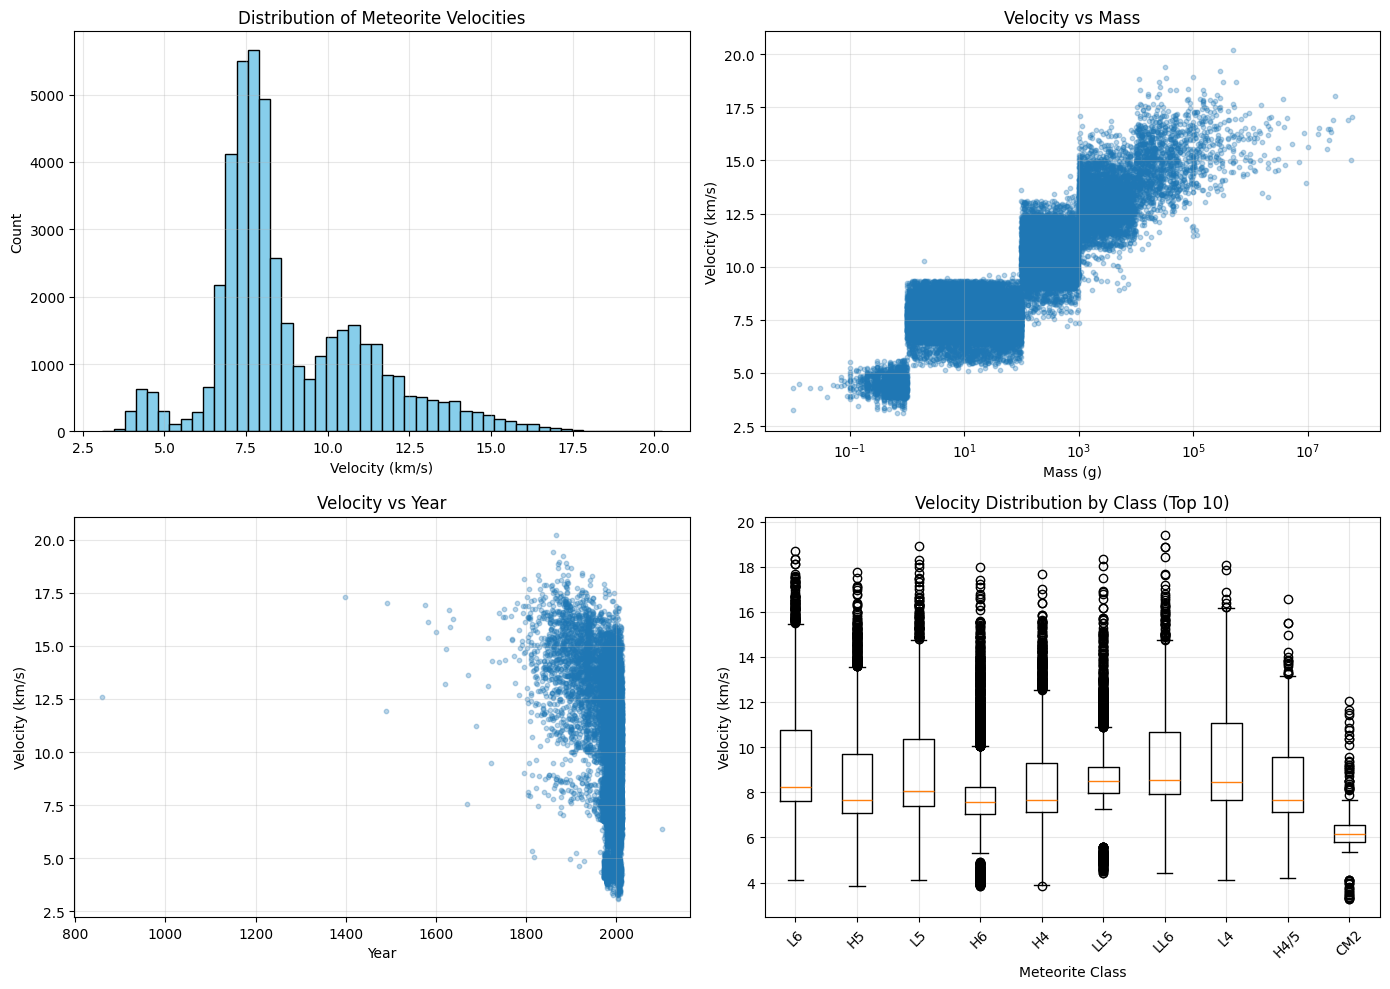


=== Ready to use! ===
Your dataset now includes 'velocity_km_s' column.
You can now use it as a feature in your model:

Example:
  X = df[['mass (g)', 'year', 'recclass_encoded', 'velocity_km_s']]
  y = df[['reclat', 'reclong']]


In [38]:
# Velocity Add
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv("Meteorite_Landings.csv")

print("Original dataset shape:", df.shape)
print("\nFirst few rows before adding velocity:")
print(df.head())

def estimate_meteorite_velocity(mass, recclass, year):
    """
    Estimate meteorite velocity based on mass, class, and year.
    
    Args:
        mass: Mass in grams
        recclass: Meteorite classification (e.g., 'H5', 'L6', 'Iron')
        year: Year of fall/find
    
    Returns:
        velocity: Estimated velocity in km/s
    """
    
    # Handle NaN/missing values
    if pd.isna(mass) or pd.isna(year) or pd.isna(recclass):
        return np.nan
    
    # Base velocities for different meteorite types (km/s)
    velocity_by_class = {
        # Ordinary Chondrites (most common)
        'H': 15.0,   'L': 16.0,   'LL': 17.0,
        
        # Carbonaceous Chondrites
        'C': 12.0,   'CI': 11.0,  'CM': 12.5,
        'CO': 13.0,  'CV': 13.5,  'CK': 14.0,  'CR': 12.0,
        
        # Enstatite Chondrites
        'E': 14.0,   'EH': 14.5,  'EL': 14.0,
        
        # Achondrites
        'Eucrite': 18.0,    'Howardite': 18.5,
        'Diogenite': 18.0,  'Aubrite': 19.0,
        'Ureilite': 17.5,   'Angrite': 18.0,
        
        # Iron meteorites
        'Iron': 20.0,       'Mesosiderite': 19.0,
        'Pallasite': 19.5,
        
        # Other types
        'Martian': 17.0,    'Lunar': 16.5,
        'R': 15.5,          'K': 14.5,
        
        # Default
        'Unknown': 15.0
    }
    
    # Extract base class (remove numbers and special characters)
    recclass_str = str(recclass).upper()
    
    # Try to find matching class
    base_velocity = velocity_by_class.get('Unknown')
    
    # Check for exact matches first
    if recclass_str in velocity_by_class:
        base_velocity = velocity_by_class[recclass_str]
    else:
        # Extract prefix (letters before numbers)
        base_class = ''.join([c for c in recclass_str if c.isalpha()])
        
        # Try progressively shorter prefixes
        for i in range(len(base_class), 0, -1):
            prefix = base_class[:i]
            if prefix in velocity_by_class:
                base_velocity = velocity_by_class[prefix]
                break
    
    # Mass effect: Larger masses survive higher velocities
    mass_kg = mass / 1000.0
    if mass_kg < 0.001:  # Very small (<1g)
        mass_factor = 0.3
    elif mass_kg < 0.1:  # Small (1-100g)
        mass_factor = 0.5
    elif mass_kg < 1.0:  # Medium (100g-1kg)
        mass_factor = 0.7
    elif mass_kg < 10.0:  # Large (1-10kg)
        mass_factor = 0.85
    elif mass_kg < 100.0:  # Very large (10-100kg)
        mass_factor = 0.95
    else:  # Massive (>100kg)
        mass_factor = 1.0
    
    # Year effect: Detection methods improved over time
    if year < 1900:
        year_factor = 1.1
    elif year < 1950:
        year_factor = 1.05
    elif year < 2000:
        year_factor = 1.0
    else:
        year_factor = 0.95
    
    # Calculate final velocity
    velocity = base_velocity * mass_factor * year_factor
    
    # Add realistic variance (±10%)
    velocity_with_noise = velocity * np.random.uniform(0.9, 1.1)
    
    return velocity_with_noise


# Add velocity column to dataset
print("\nCalculating velocities for all meteorites...")
df['velocity_km_s'] = df.apply(
    lambda row: estimate_meteorite_velocity(
        row['mass (g)'], 
        row['recclass'], 
        row['year']
    ), 
    axis=1
)

print("\nDataset with velocity added:")
print(df.head(10))

print("\n=== Velocity Statistics ===")
print(f"Total meteorites: {len(df)}")
print(f"With velocity: {df['velocity_km_s'].notna().sum()}")
print(f"Missing velocity: {df['velocity_km_s'].isna().sum()}")
print(f"\nVelocity range: {df['velocity_km_s'].min():.2f} - {df['velocity_km_s'].max():.2f} km/s")
print(f"Mean velocity: {df['velocity_km_s'].mean():.2f} km/s")
print(f"Median velocity: {df['velocity_km_s'].median():.2f} km/s")

# Show velocity distribution by class
print("\n=== Velocity by Meteorite Class (Top 10) ===")
class_velocity = df.groupby('recclass')['velocity_km_s'].agg(['mean', 'count']).sort_values('count', ascending=False).head(10)
print(class_velocity)

# Save the updated dataset
output_filename = "Meteorite_Landings_with_velocity.csv"
df.to_csv(output_filename, index=False)
print(f"\n✓ Dataset saved as '{output_filename}'")

# Optional: Visualize velocity distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Velocity distribution histogram
axes[0, 0].hist(df['velocity_km_s'].dropna(), bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Velocity (km/s)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Meteorite Velocities')
axes[0, 0].grid(alpha=0.3)

# 2. Velocity vs Mass
axes[0, 1].scatter(df['mass (g)'], df['velocity_km_s'], alpha=0.3, s=10)
axes[0, 1].set_xlabel('Mass (g)')
axes[0, 1].set_ylabel('Velocity (km/s)')
axes[0, 1].set_xscale('log')
axes[0, 1].set_title('Velocity vs Mass')
axes[0, 1].grid(alpha=0.3)

# 3. Velocity vs Year
axes[1, 0].scatter(df['year'], df['velocity_km_s'], alpha=0.3, s=10)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Velocity (km/s)')
axes[1, 0].set_title('Velocity vs Year')
axes[1, 0].grid(alpha=0.3)

# 4. Velocity by top classes
top_classes = df['recclass'].value_counts().head(10).index
df_top = df[df['recclass'].isin(top_classes)]
axes[1, 1].boxplot([df_top[df_top['recclass'] == c]['velocity_km_s'].dropna() 
                     for c in top_classes],
                    labels=top_classes)
axes[1, 1].set_xlabel('Meteorite Class')
axes[1, 1].set_ylabel('Velocity (km/s)')
axes[1, 1].set_title('Velocity Distribution by Class (Top 10)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Ready to use! ===")
print("Your dataset now includes 'velocity_km_s' column.")
print("You can now use it as a feature in your model:")
print("\nExample:")
print("  X = df[['mass (g)', 'year', 'recclass_encoded', 'velocity_km_s']]")
print("  y = df[['reclat', 'reclong']]")

In [151]:
# GradientBoostingRegressor Model Training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=40)

# Train model
best_gbr = MultiOutputRegressor(
    GradientBoostingRegressor(
        n_estimators=800,
        learning_rate=0.01,   
        max_depth=7,
        subsample=0.9,
        random_state=42
    )
)

print("\n🚀 Training model with velocity feature...")
best_gbr.fit(X_train, y_train)
y_pred = best_gbr.predict(X_test)
print(y_pred)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print("\nMSE:", mse)
print("RMSE:", np.sqrt(mse), "degrees")


🚀 Training model with velocity feature...
[[-61.12787278  94.48734346]
 [-73.48702005  77.97356889]
 [-78.87356698 108.46405089]
 ...
 [-19.90979249  56.53231024]
 [-30.46484703  55.87284083]
 [-64.00809643  60.11371981]]

MSE: 1845.7762086919786
RMSE: 42.962497700808534 degrees


In [147]:
# Model Testing
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
residuals = y_test_array - y_pred
lat_std = np.std(residuals[:, 0])
long_std = np.std(residuals[:, 1])
print(f"Latitude Std: ±{lat_std:.2f}°")
print(f"Longitude Std: ±{long_std:.2f}°")

# Feature importance
print("\n=== Feature Importance ===")
importances = best_gbr.estimators_[0].feature_importances_
for feat, imp in zip(X.columns, importances):
    print(f"{feat}: {imp:.4f}")


# Example prediction
sample_velocity = 14.592207# km/s - you can calculate this with your velocity function
lat, long, velocity, uncertainty= predict_meteorite_landing(21, 1880,"L5",sample_velocity)
print(f"\nExample prediction: ({pred_lat:.2f}°, {pred_long:.2f}°)")

Latitude Std: ±25.94°
Longitude Std: ±54.90°

=== Feature Importance ===
mass (g): 0.2066
year: 0.3572
recclass_encoded: 0.0903
velocity_km_s: 0.0108
mass_log: 0.2637
velocity_squared: 0.0107
momentum: 0.0235
kinetic_energy: 0.0183
year_modern: 0.0029
mass_velocity_interaction: 0.0161

Example prediction: (35.21°, 13.28°)


Latitude Std: 25.94, Longitude Std: 54.90
Estimated velocity: 8.80 km/s
Base Predicted location (lat, long): [17.29, -4.91]


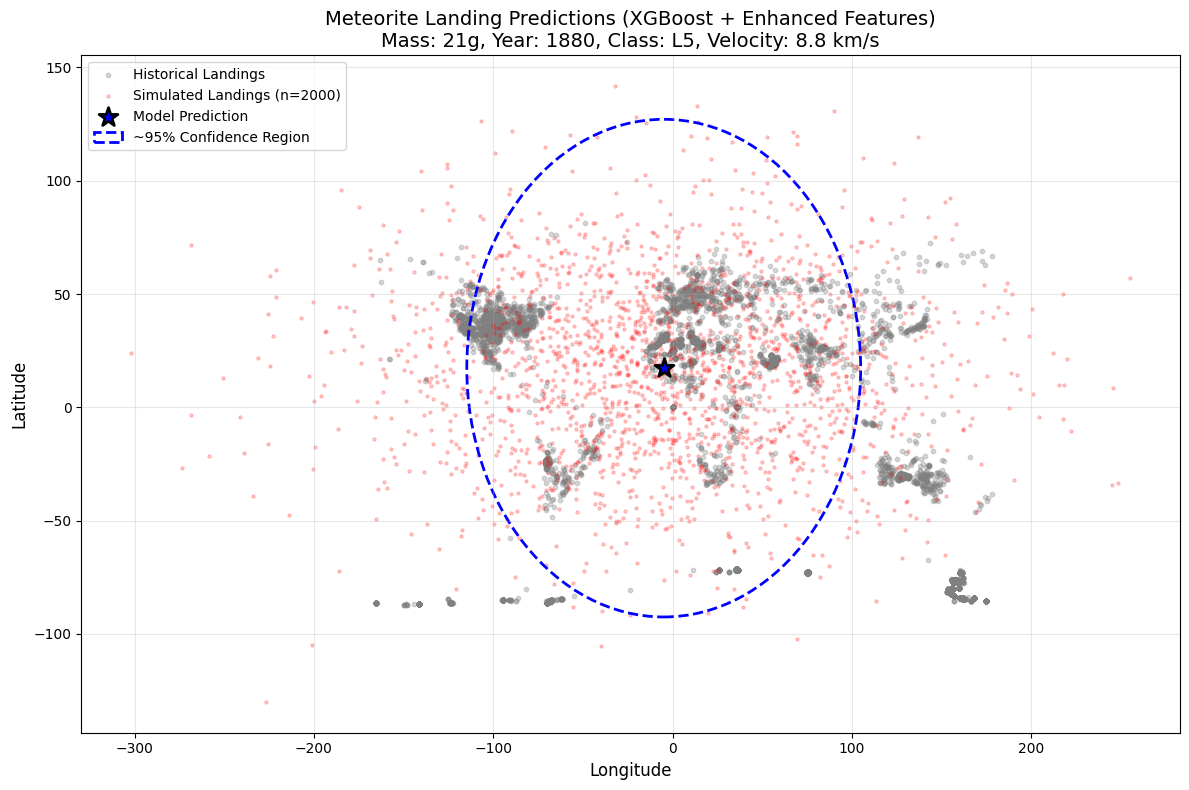

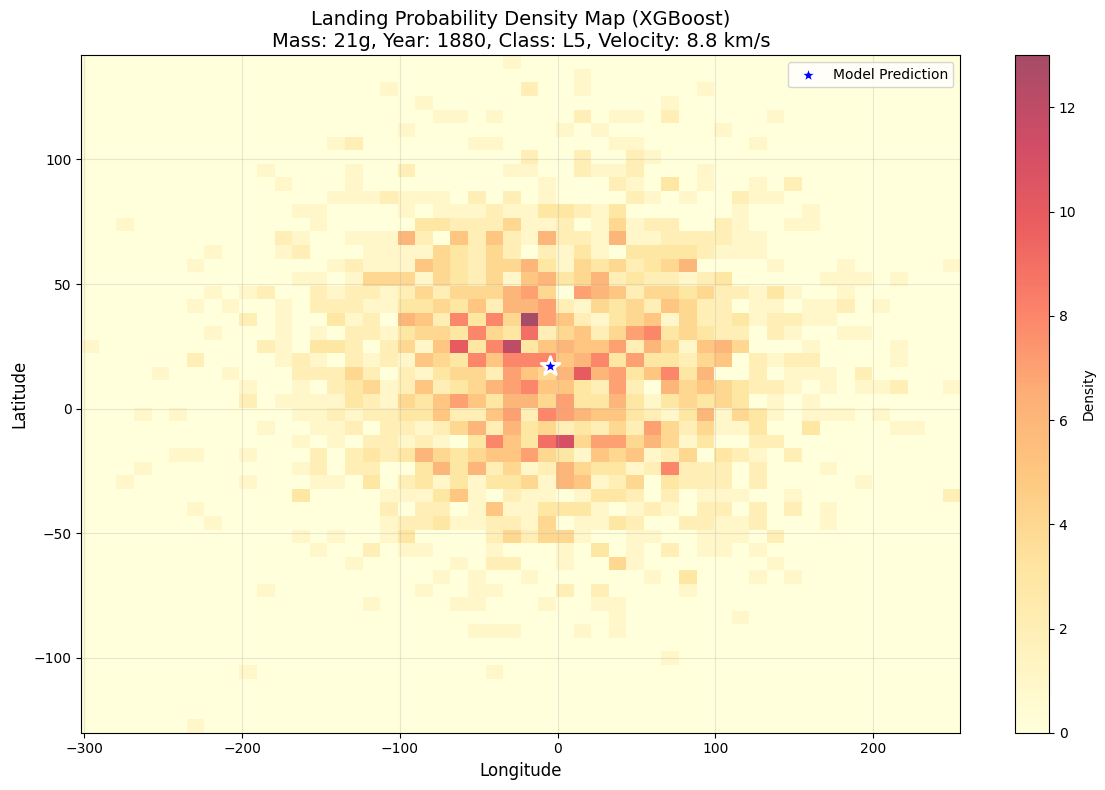


=== Prediction Statistics ===
Input Parameters:
  Mass: 21g
  Year: 1880
  Class: L5
  Velocity: 8.80 km/s

Predicted Landing:
  Latitude: 17.29°
  Longitude: -4.91°

Simulation Statistics:
  Mean Latitude: 16.36°
  Mean Longitude: -4.20°
  Latitude Range: [-130.02, 141.75]
  Longitude Range: [-301.84, 255.11]
  95% confidence: ±109.81°

=== Comparing Different Scenarios ===
Base Predicted location (lat, long): [17.29, -4.91]
Base Predicted location (lat, long): [10.60, -59.15]
Base Predicted location (lat, long): [26.42, -82.57]
Base Predicted location (lat, long): [12.02, -30.53]


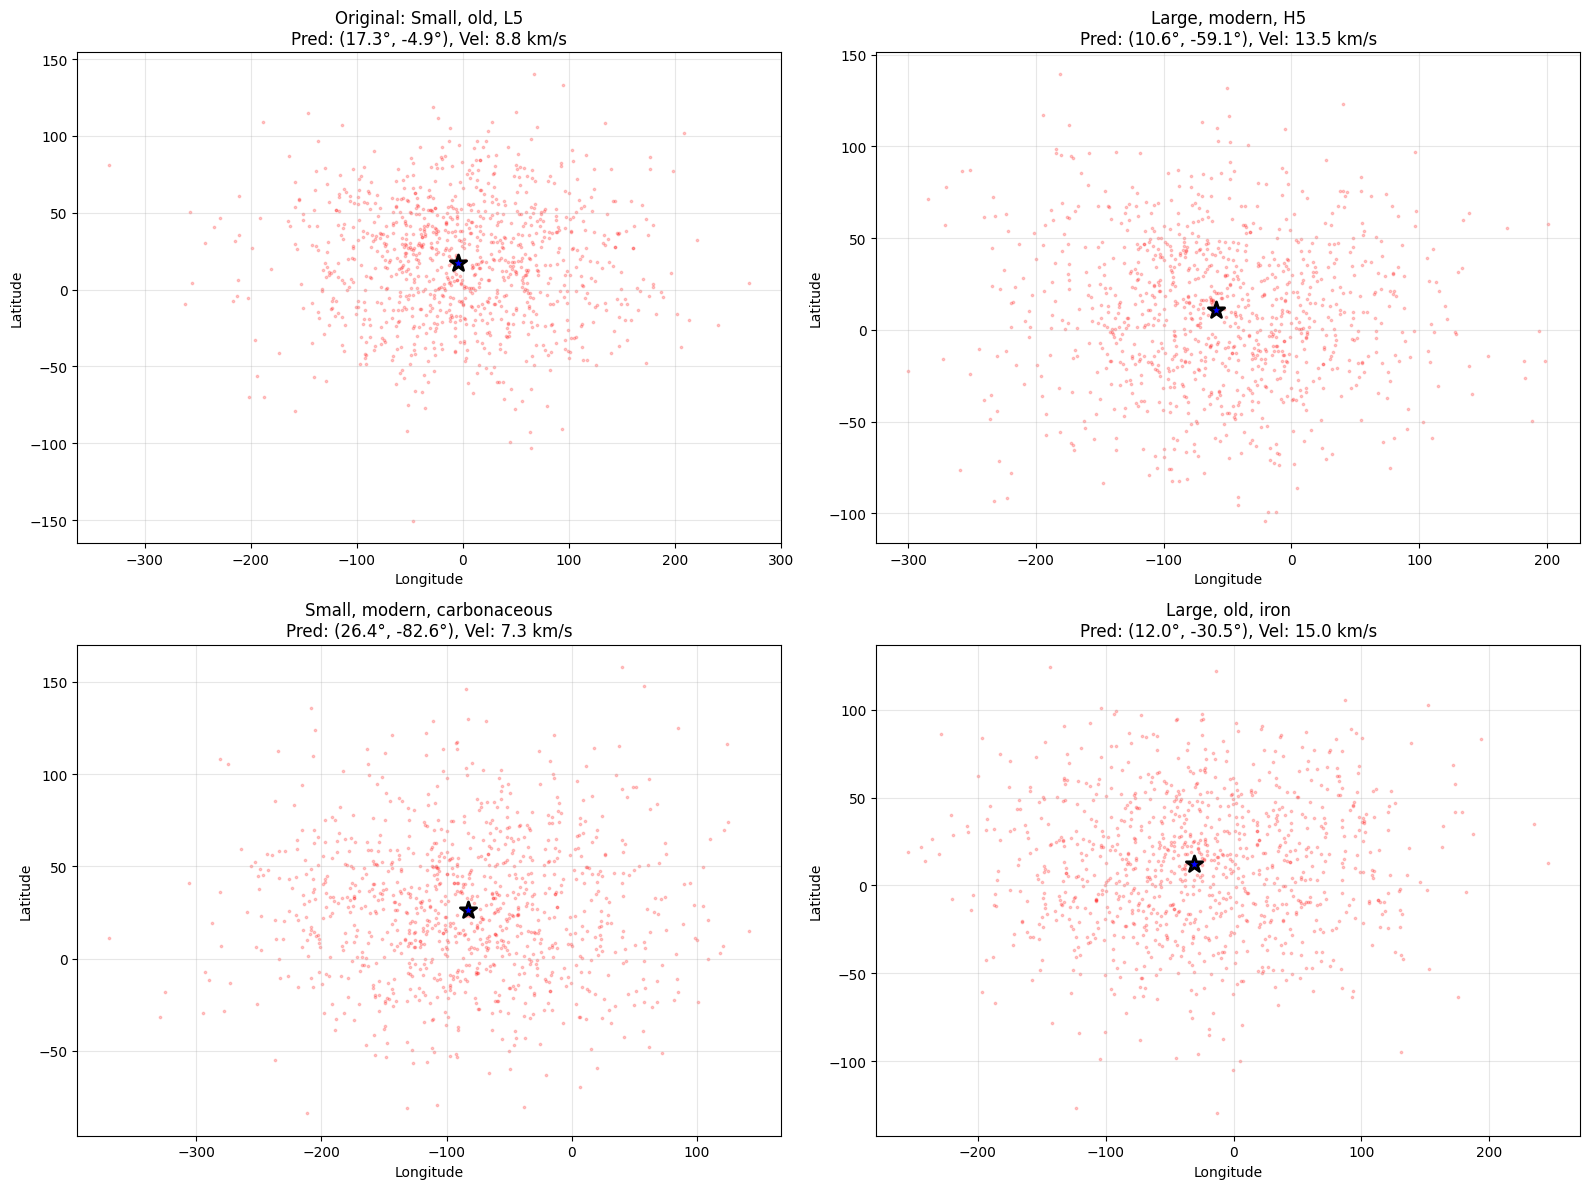


✅ All visualizations complete!


In [149]:
# Front-end shit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate uncertainty from your model (residuals)
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
residuals = y_test_array - y_pred
lat_std = np.std(residuals[:, 0])
long_std = np.std(residuals[:, 1])
print(f"Latitude Std: {lat_std:.2f}, Longitude Std: {long_std:.2f}")

def estimate_meteorite_velocity(mass, recclass, year):
    """Calculate velocity for a meteorite"""
    velocity_by_class = {
        'H': 15.0, 'L': 16.0, 'LL': 17.0,
        'C': 12.0, 'CI': 11.0, 'CM': 12.5, 'CO': 13.0, 'CV': 13.5,
        'E': 14.0, 'Iron': 20.0, 'Unknown': 15.0
    }
    
    base_class = ''.join([c for c in str(recclass).upper() if c.isalpha()])
    base_velocity = velocity_by_class.get(base_class, 15.0)
    
    mass_kg = mass / 1000.0
    if mass_kg < 0.001: mass_factor = 0.3
    elif mass_kg < 0.1: mass_factor = 0.5
    elif mass_kg < 1.0: mass_factor = 0.7
    elif mass_kg < 10.0: mass_factor = 0.85
    elif mass_kg < 100.0: mass_factor = 0.95
    else: mass_factor = 1.0
    
    year_factor = 1.1 if year < 1900 else (1.05 if year < 1950 else (1.0 if year < 2000 else 0.95))
    
    return base_velocity * mass_factor * year_factor


def simulate_landings_from_model(model, scaler, input_mass, input_year, recclass_encoded, 
                                  velocity, n_samples=1000, uncertainty_factor=1.0):
    """
    Generate possible landing locations based on model prediction + uncertainty
    NOW WITH ENHANCED FEATURES!
    
    Args:
        model: Trained MultiOutputRegressor (XGBoost or GradientBoosting)
        scaler: StandardScaler used for input features
        input_mass: Mass in grams
        input_year: Year of predicted landing
        recclass_encoded: Encoded meteorite class
        velocity: Calculated velocity in km/s
        n_samples: Number of simulated landings to generate
        uncertainty_factor: Multiplier for uncertainty (1.0 = use model's error)
    """
    # Calculate all enhanced features
    mass_log = np.log1p(input_mass)
    velocity_squared = velocity ** 2
    momentum = input_mass * velocity
    kinetic_energy = 0.5 * input_mass * (velocity ** 2)
    year_modern = 1 if input_year >= 2000 else 0
    mass_velocity_interaction = mass_log * velocity
    
    # Prepare input with ALL features (must match training!)
    sample = pd.DataFrame([[
        input_mass, input_year, recclass_encoded, velocity,
        mass_log, velocity_squared, momentum, kinetic_energy,
        year_modern, mass_velocity_interaction
    ]], columns=[
        "mass (g)", "year", "recclass_encoded", "velocity_km_s",
        "mass_log", "velocity_squared", "momentum", "kinetic_energy",
        "year_modern", "mass_velocity_interaction"
    ])
    
    sample_scaled = scaler.transform(sample)
    
    # Get base prediction
    base_prediction = model.predict(sample_scaled)[0]
    pred_lat, pred_long = base_prediction
    
    print(f"Base Predicted location (lat, long): [{pred_lat:.2f}, {pred_long:.2f}]")
    
    # Generate samples around the prediction using model's uncertainty
    simulated_lats = np.random.normal(pred_lat, lat_std * uncertainty_factor, n_samples)
    simulated_longs = np.random.normal(pred_long, long_std * uncertainty_factor, n_samples)
    
    simulated_coords = np.column_stack([simulated_lats, simulated_longs])
    
    return simulated_coords, base_prediction


# ============================================
# EXAMPLE PREDICTION
# ============================================

# Input parameters
input_mass = 21  # grams
input_year = 1880
input_class = "L5"  
recclass_encoded = le.transform([input_class])[0]

# Calculate velocity
velocity = estimate_meteorite_velocity(input_mass, input_class, input_year)
print(f"Estimated velocity: {velocity:.2f} km/s")

# Simulate landings
sim_coords, base_pred = simulate_landings_from_model(
    model=xgb_model,  # or best_gbr if using GradientBoosting
    scaler=scaler,
    input_mass=input_mass,
    input_year=input_year,
    recclass_encoded=recclass_encoded,
    velocity=velocity,
    n_samples=2000,
    uncertainty_factor=1.5
)

# ============================================
# VISUALIZATION 1: Scatter Plot
# ============================================

plt.figure(figsize=(12, 8))

# Plot historical data
if 'df_clean' in locals() or 'df' in locals():
    df_plot = df_clean if 'df_clean' in locals() else df
    plt.scatter(df_plot["reclong"], df_plot["reclat"], 
                alpha=0.3, s=10, c='gray', 
                label="Historical Landings")

# Plot simulated landings
plt.scatter(sim_coords[:, 1], sim_coords[:, 0], 
            alpha=0.2, s=5, color="red", 
            label=f"Simulated Landings (n={len(sim_coords)})")

# Plot base prediction
plt.scatter(base_pred[1], base_pred[0], 
            s=200, color="blue", marker="*", 
            edgecolors='black', linewidths=2,
            label="Model Prediction", zorder=5)

# Add uncertainty circle (2 standard deviations ≈ 95% confidence)
circle = plt.Circle((base_pred[1], base_pred[0]), 
                     2 * max(lat_std, long_std), 
                     color='blue', fill=False, 
                     linestyle='--', linewidth=2,
                     label='~95% Confidence Region')
plt.gca().add_patch(circle)

plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.title(f"Meteorite Landing Predictions (XGBoost + Enhanced Features)\n"
          f"Mass: {input_mass}g, Year: {input_year}, Class: {input_class}, Velocity: {velocity:.1f} km/s", 
          fontsize=14)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))

# Create 2D histogram
h = ax.hist2d(sim_coords[:, 1], sim_coords[:, 0], 
              bins=50, cmap='YlOrRd', alpha=0.7)
plt.colorbar(h[3], ax=ax, label='Density')

# Plot base prediction
ax.scatter(base_pred[1], base_pred[0], 
           s=200, color="blue", marker="*", 
           edgecolors='white', linewidths=2,
           label="Model Prediction", zorder=5)

ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.set_title(f"Landing Probability Density Map (XGBoost)\n"
             f"Mass: {input_mass}g, Year: {input_year}, Class: {input_class}, Velocity: {velocity:.1f} km/s", 
             fontsize=14)
ax.legend(loc='best')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# STATISTICS
# ============================================

print("\n=== Prediction Statistics ===")
print(f"Input Parameters:")
print(f"  Mass: {input_mass}g")
print(f"  Year: {input_year}")
print(f"  Class: {input_class}")
print(f"  Velocity: {velocity:.2f} km/s")
print(f"\nPredicted Landing:")
print(f"  Latitude: {base_pred[0]:.2f}°")
print(f"  Longitude: {base_pred[1]:.2f}°")
print(f"\nSimulation Statistics:")
print(f"  Mean Latitude: {np.mean(sim_coords[:, 0]):.2f}°")
print(f"  Mean Longitude: {np.mean(sim_coords[:, 1]):.2f}°")
print(f"  Latitude Range: [{np.min(sim_coords[:, 0]):.2f}, {np.max(sim_coords[:, 0]):.2f}]")
print(f"  Longitude Range: [{np.min(sim_coords[:, 1]):.2f}, {np.max(sim_coords[:, 1]):.2f}]")
print(f"  95% confidence: ±{2 * max(lat_std, long_std):.2f}°")


# ============================================
# BONUS: Multiple Scenarios Comparison
# ============================================

print("\n=== Comparing Different Scenarios ===")

scenarios = [
    (21, 1880, "L5", "Original: Small, old, L5"),
    (10000, 2030, "H5", "Large, modern, H5"),
    (500, 2025, "CI1", "Small, modern, carbonaceous"),
    (50000, 1900, "Iron", "Large, old, iron"),
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (mass, year, rec_class, description) in enumerate(scenarios):
    vel = estimate_meteorite_velocity(mass, rec_class, year)
    rec_encoded = le.transform([rec_class])[0]
    
    sim, pred = simulate_landings_from_model(
        model=xgb_model,
        scaler=scaler,
        input_mass=mass,
        input_year=year,
        recclass_encoded=rec_encoded,
        velocity=vel,
        n_samples=1000,
        uncertainty_factor=1.5
    )
    
    # Plot on subplot
    axes[idx].scatter(sim[:, 1], sim[:, 0], alpha=0.2, s=3, color="red")
    axes[idx].scatter(pred[1], pred[0], s=150, color="blue", marker="*", 
                     edgecolors='black', linewidths=2, zorder=5)
    axes[idx].set_xlabel("Longitude")
    axes[idx].set_ylabel("Latitude")
    axes[idx].set_title(f"{description}\nPred: ({pred[0]:.1f}°, {pred[1]:.1f}°), Vel: {vel:.1f} km/s")
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ All visualizations complete!")

In [150]:
# XGBoost Model Training
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=40
)

# ============================================
# 2. TRAIN XGBOOST MODEL
# ============================================
print("\n🚀 Training XGBoost model...")

xgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=800,       # Number of trees
        learning_rate=0.01,      # Step size shrinkage
        max_depth=8,             # Maximum tree depth
        subsample=0.85,          # Row sampling
        colsample_bytree=0.8,    # Column sampling
        min_child_weight=3,      # Minimum sum of weights
        gamma=0.1,               # Minimum loss reduction
        reg_alpha=0.1,           # L1 regularization
        reg_lambda=1.0,          # L2 regularization
        random_state=42,
        n_jobs=-1                # Use all CPU cores
    )
)

xgb_model.fit(X_train, y_train)
print("✓ Model trained successfully!")

print("\n📈 Evaluating model...")

y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Per-coordinate metrics
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
lat_rmse = np.sqrt(mean_squared_error(y_test_array[:, 0], y_pred[:, 0]))
long_rmse = np.sqrt(mean_squared_error(y_test_array[:, 1], y_pred[:, 1]))

print("\n📊 Model Performance:")
print(f"  Overall RMSE: {rmse:.4f}°")
print(f"  Latitude RMSE: {lat_rmse:.4f}°")
print(f"  Longitude RMSE: {long_rmse:.4f}°")
print(f"  R² Score: {r2:.4f}")
print(f"  MSE: {mse:.4f}")

# Calculate prediction uncertainty
residuals = y_test_array - y_pred
lat_std = np.std(residuals[:, 0])
long_std = np.std(residuals[:, 1])
print(f"\n📏 Prediction Uncertainty:")
print(f"  Latitude Std: ±{lat_std:.2f}°")
print(f"  Longitude Std: ±{long_std:.2f}°")


def predict_meteorite_landing(mass, year, recclass, velocity):
    """
    Predict meteorite landing location using XGBoost
    
    Args:
        mass: Mass in grams
        year: Year of predicted landing
        recclass: Meteorite class (e.g., 'H5', 'L6', 'Iron')
    
    Returns:
        lat, long, velocity, uncertainty
    """
    
    # Encode class
    try:
        recclass_encoded = le.transform([recclass])[0]
    except:
        print(f"⚠️  Unknown class '{recclass}', using default")
        recclass_encoded = le.transform([df['recclass'].mode()[0]])[0]
    
    # Calculate engineered features
    mass_log = np.log1p(mass)
    velocity_squared = velocity ** 2
    momentum = mass * velocity
    kinetic_energy = 0.5 * mass * (velocity ** 2)
    year_modern = 1 if year >= 2000 else 0
    mass_velocity_interaction = mass_log * velocity
    
    # Prepare input
    sample = pd.DataFrame([[
        mass, year, recclass_encoded, velocity,
        mass_log, velocity_squared, momentum, kinetic_energy,
        year_modern, mass_velocity_interaction
    ]], columns=X.columns)
    
    # Scale and predict
    sample_scaled = scaler.transform(sample)
    prediction = xgb_model.predict(sample_scaled)[0]
    
    return prediction[0], prediction[1], velocity, (lat_std, long_std)



🚀 Training XGBoost model...
✓ Model trained successfully!

📈 Evaluating model...

📊 Model Performance:
  Overall RMSE: 42.9425°
  Latitude RMSE: 25.9476°
  Longitude RMSE: 54.9075°
  R² Score: 0.6354
  MSE: 1844.0562

📏 Prediction Uncertainty:
  Latitude Std: ±25.94°
  Longitude Std: ±54.90°


In [153]:
from flask import Flask, jsonify, request, redirect, session    
from flask_cors import CORS
import json
app = Flask(__name__)
CORS(app)

@app.route('/get_data', methods=["POST"])
def test(data):
    print(data.json)
    #grams = request.    
    #year = 1952
    #types = "EH4"
    #velocity = 14.592207
    #lat, long, velocity, uncertainty = predict_meteorite_landing(grams,year,types,velocity)
    #
    #aite = {
    #    "latitude": float(lat),      # Convert to Python float
    #    "longitude": float(long),    # Convert to Python float
    #    "std": {
    #        "lat": float(uncertainty[0]),   # Unpack uncertainty tuple
    #        "long": float(uncertainty[1])
    #    }
    #}
    return "PAULO"

In [ ]:
app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [05/Oct/2025 17:57:02] "GET / HTTP/1.1" 404 -
